In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="ticks")

In [2]:
GTC_DATA_DIR = "/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/data/gtc_quakes_data"
LABQUAKES_DATA_DIR = f"{GTC_DATA_DIR}/labquakes"
MARONE_DATA_DIR = f"{LABQUAKES_DATA_DIR}/Marone"

In [3]:
p4581_FILE_PATH = f"{MARONE_DATA_DIR}/p4581/p4581.txt"
with open(p4581_FILE_PATH, "r") as file:
    lines = [next(file) for _ in range(10)]
print("".join(lines))

number of records = 3478640
            col 1       col 2       col 3       col 4       col 5       col 6       col 9
          LP_Disp  Shr_stress    nor_disp  Nor_stress        Time        Sync   Samp_Freq
              mic         MPa      micron         MPa         sec       Volts          Hz
     3478640 recs3478640 recs3478640 recs3478640 recs3478640 recs3478640 recs3478640 recs
    0           -0           0          -0       1e-18           1     3.29854           1
    1           -0           0          -0       1e-18           2     3.29853           1
    2           -0           0          -0       1e-18           3     3.29853           1
    3           -0           0          -0       1e-18           4     3.29854           1
    4           -0           0          -0       1e-18           5     3.29855           1



In [4]:
with open(p4581_FILE_PATH, "r") as file:
    df = pd.read_csv(file, delim_whitespace=True, skiprows=4)

df.columns = [
    "id",
    "lp_disp",
    "shr_stress",
    "nor_disp",
    "nor_stress",
    "time",
    "sync",
    "samp_freq",
]

df = df.drop(["id"], axis=1)

In [5]:
df.head()

,lp_disp,shr_stress,nor_disp,nor_stress,time,sync,samp_freq
0,0.0,0.0,-0.0,1.000000e-18,1.0,3.29854,1
1,0.0,0.0,-0.0,1.000000e-18,2.0,3.29853,1
2,0.0,0.0,-0.0,1.000000e-18,3.0,3.29853,1
3,0.0,0.0,-0.0,1.000000e-18,4.0,3.29854,1
4,0.0,0.0,-0.0,1.000000e-18,5.0,3.29855,1


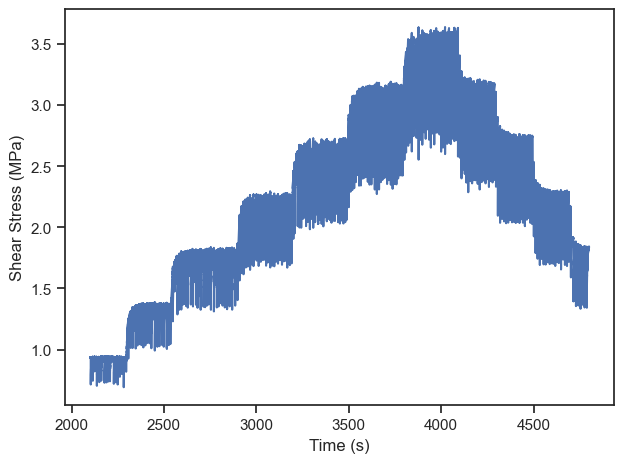

In [6]:
fig = plt.figure()
ax = fig.gca()

ax.plot(
    df[(df["time"] >= 2100) & (df["time"] < 4800)]["time"],
    df[(df["time"] >= 2100) & (df["time"] < 4800)]["shr_stress"],
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Shear Stress (MPa)")

plt.tight_layout()
plt.show()

In [7]:
df = df[(df["time"] >= 2100) & (df["time"] < 4800)]
df.reset_index(drop=True, inplace=True)
df.head()

,lp_disp,shr_stress,nor_disp,nor_stress,time,sync,samp_freq
0,3057.39,0.932700,2072.64,2.01227,2100.0,3.29853,1000
1,3060.88,0.932965,2072.54,2.01242,2100.0,3.29851,1000
2,3062.33,0.933241,2072.53,2.01058,2100.0,3.29855,1000
3,3057.01,0.932987,2072.59,2.01066,2100.0,3.29853,1000
4,3062.42,0.933346,2072.62,2.01216,2100.0,3.29854,1000


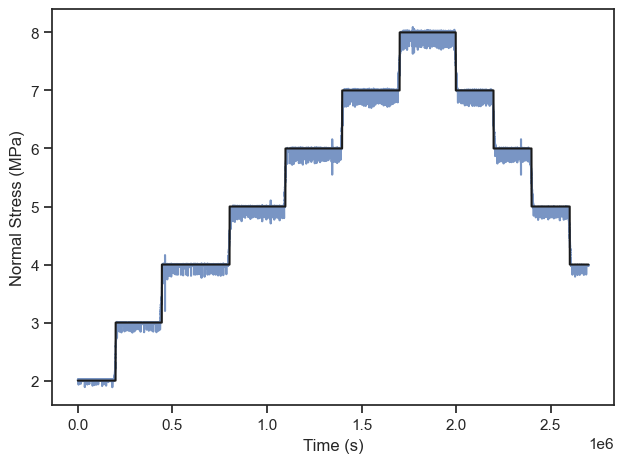

In [8]:
window_size = 100

df["smoothed_nor_stress"] = (
    df["nor_stress"].rolling(window_size, center=True).mean()
)
df["target_nor_stress"] = (
    df["smoothed_nor_stress"].fillna(0).round().astype(int)
)
df = df[df["target_nor_stress"] != 0]

fig = plt.figure()
ax = fig.gca()

ax.plot(df["nor_stress"], alpha=0.75)
ax.plot(df["target_nor_stress"], c="k")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Normal Stress (MPa)")

plt.tight_layout()
plt.show()

In [9]:
segment_indices = np.where(df["target_nor_stress"].diff() != 0)[0]
segment_indices = list(segment_indices) + [len(df)]

In [10]:
dfs = []

for idx in range(1, len(segment_indices)):
    a_idx = segment_indices[idx - 1] + int(30e3)
    b_idx = segment_indices[idx] - int(10e3)
    subset_df = df.iloc[a_idx:b_idx]
    dfs.append(subset_df)

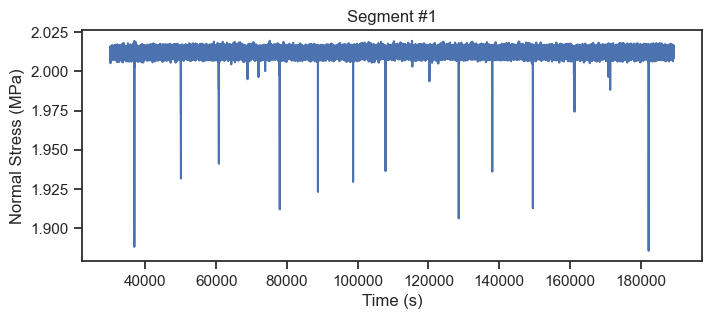

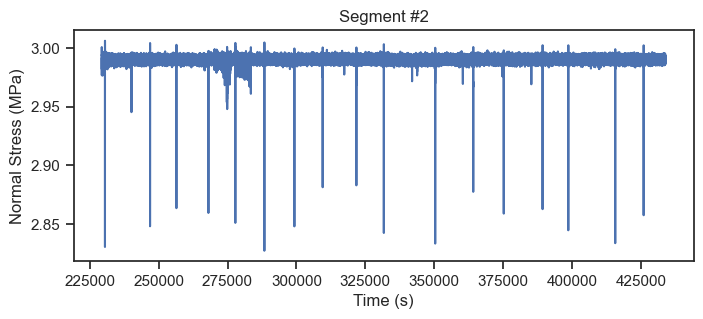

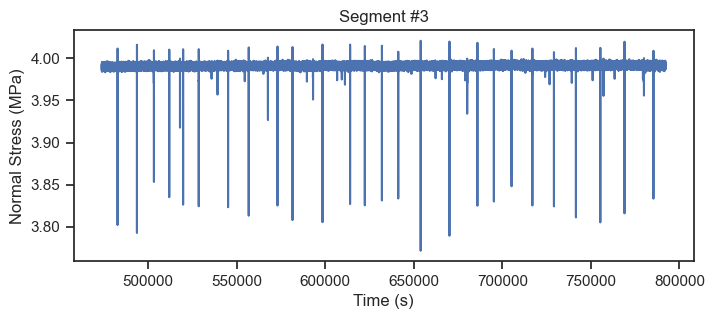

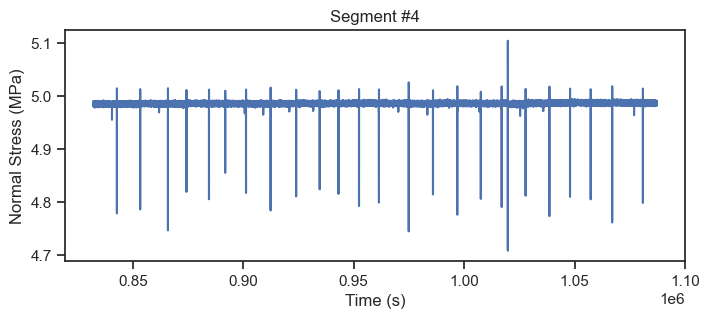

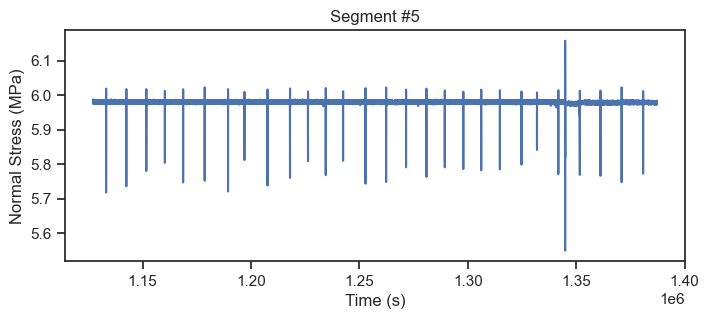

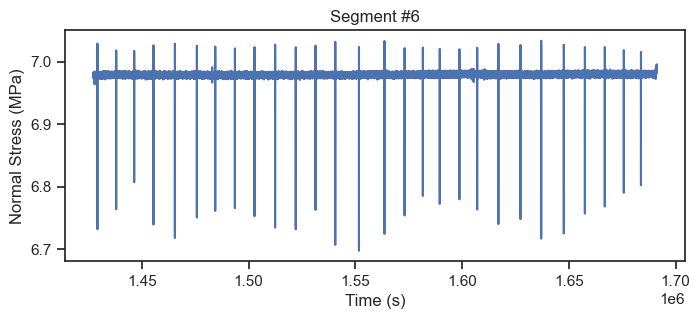

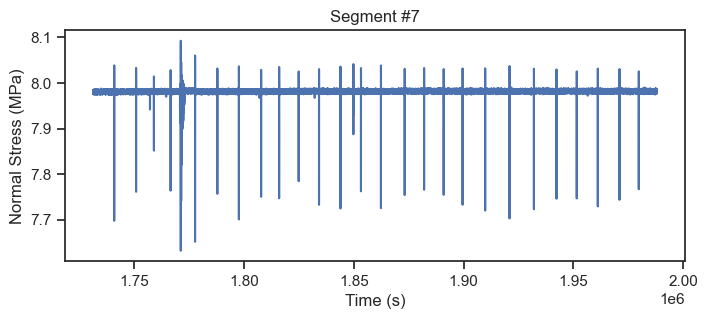

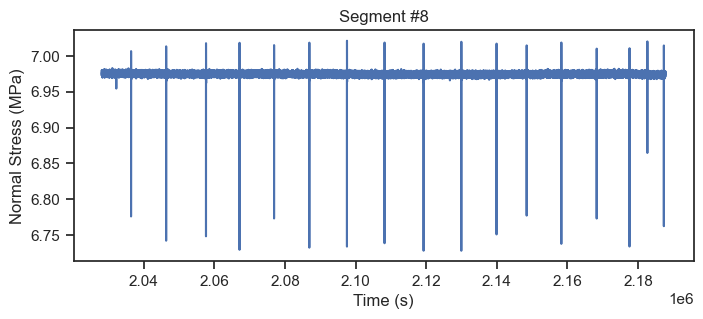

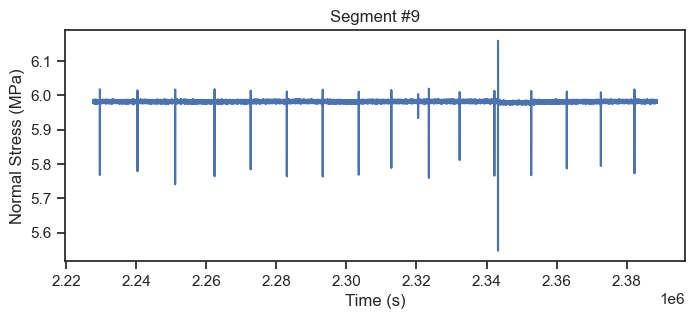

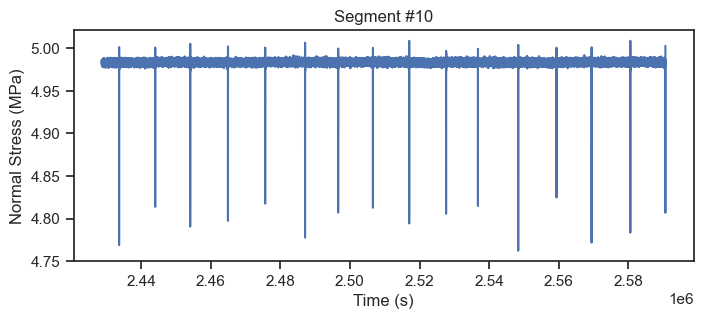

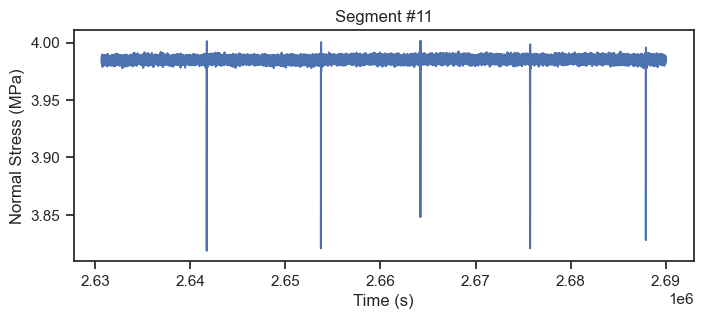

In [11]:
for idx in range(len(dfs)):
    fig = plt.figure(figsize=(8, 3))
    ax = fig.gca()
    ax.plot(dfs[idx]["nor_stress"])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Normal Stress (MPa)")
    plt.title(f"Segment #{idx+1}")
    plt.show()

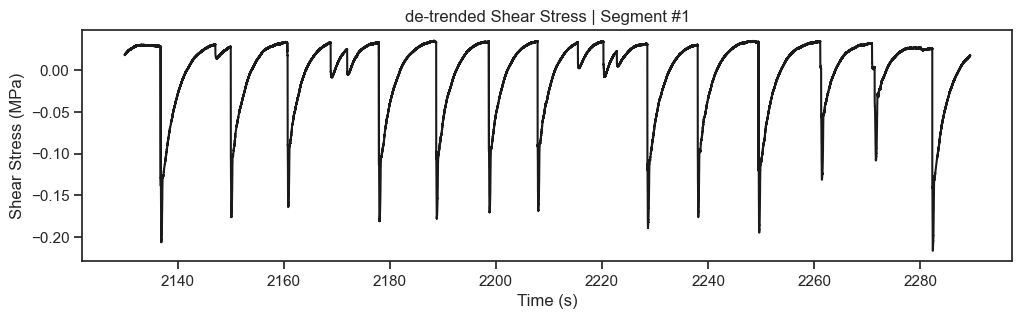

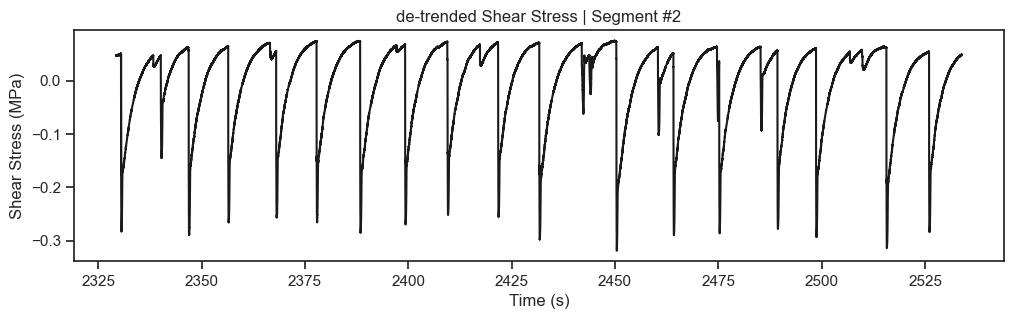

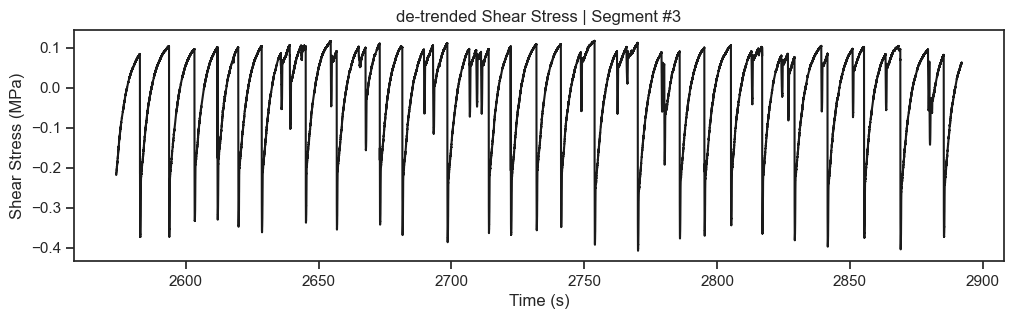

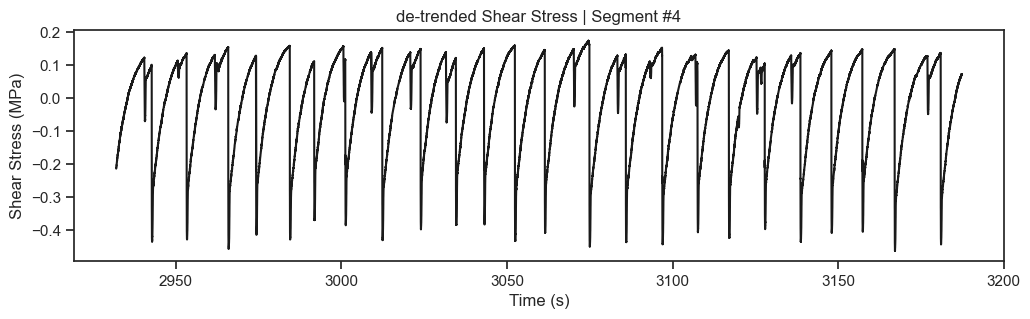

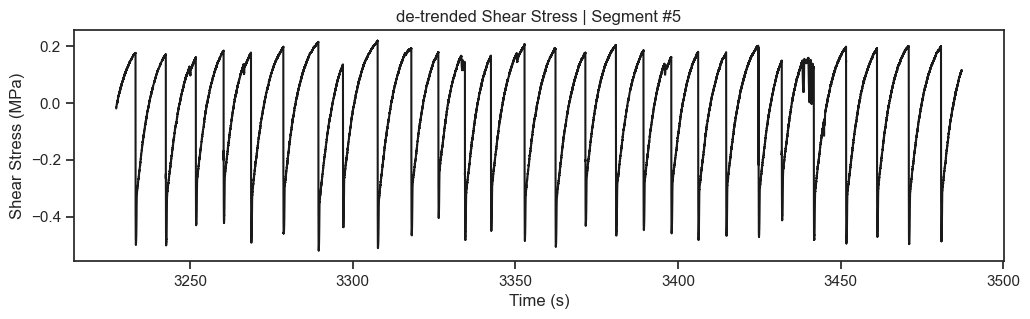

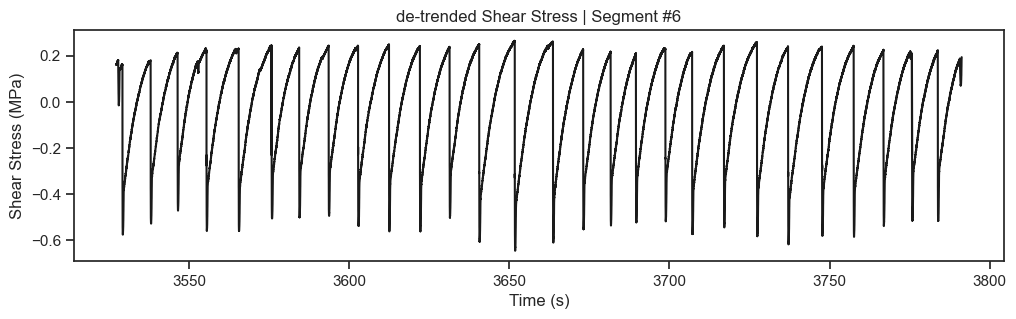

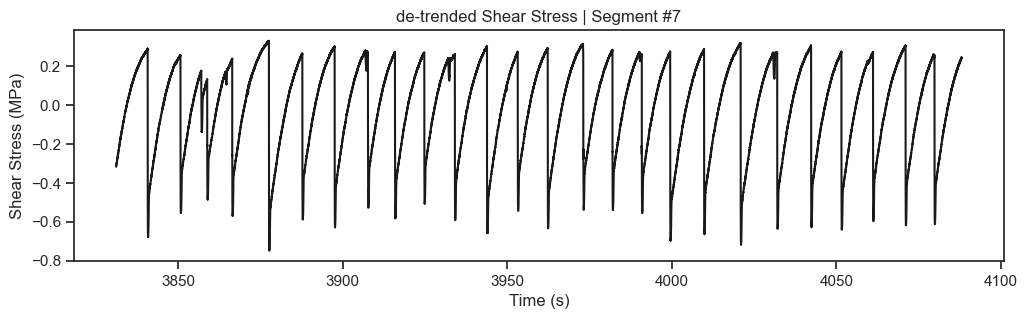

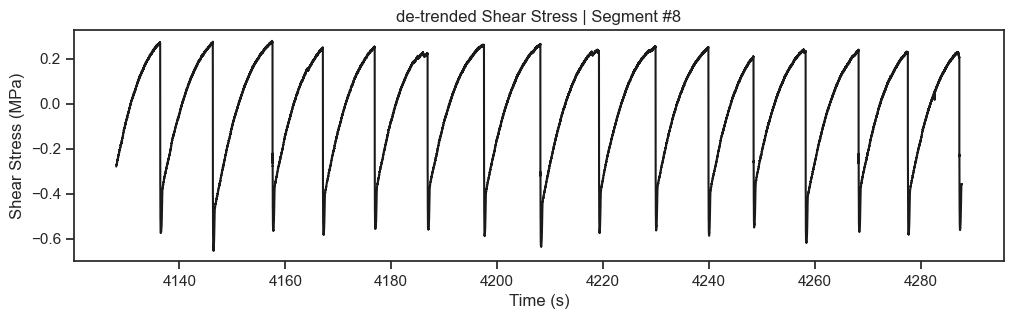

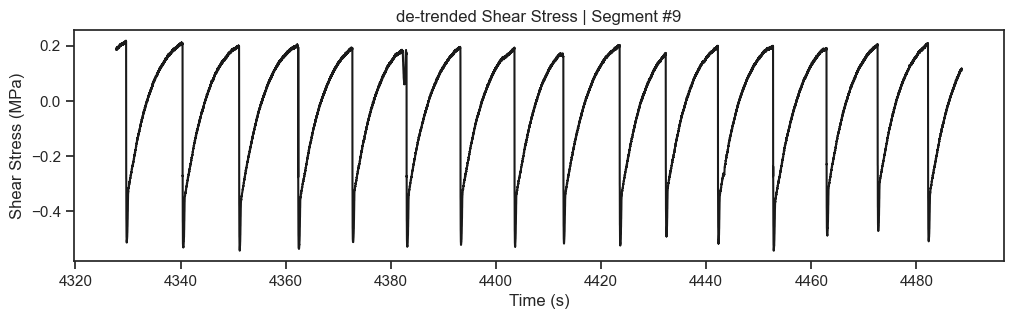

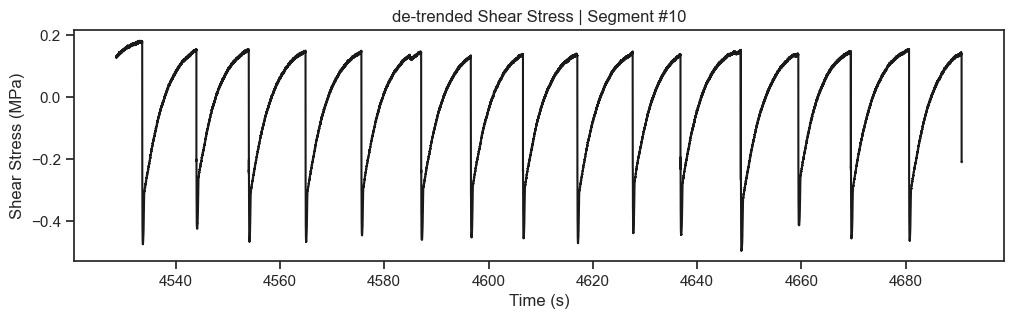

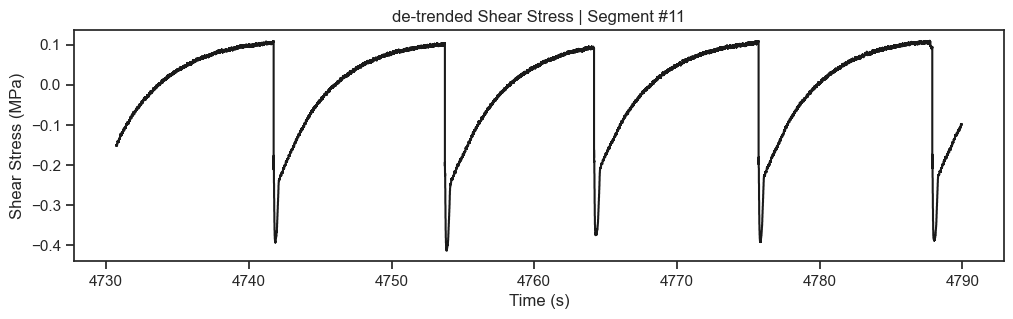

In [12]:
def detrend_first_order_poly(x, y):
    p = np.polyfit(x, y, deg=1)
    y_det = y - (p[0] * x + p[1])
    return y_det


for idx in range(len(dfs)):
    subset_df = dfs[idx]
    x = subset_df["time"]
    y = subset_df["shr_stress"]
    y_det = detrend_first_order_poly(x, y)

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    plt.plot(x, y_det, "-k")
    plt.xlabel("Time (s)")
    plt.ylabel("Shear Stress (MPa)")
    plt.title(f"de-trended Shear Stress | Segment #{idx+1}")
    plt.show()